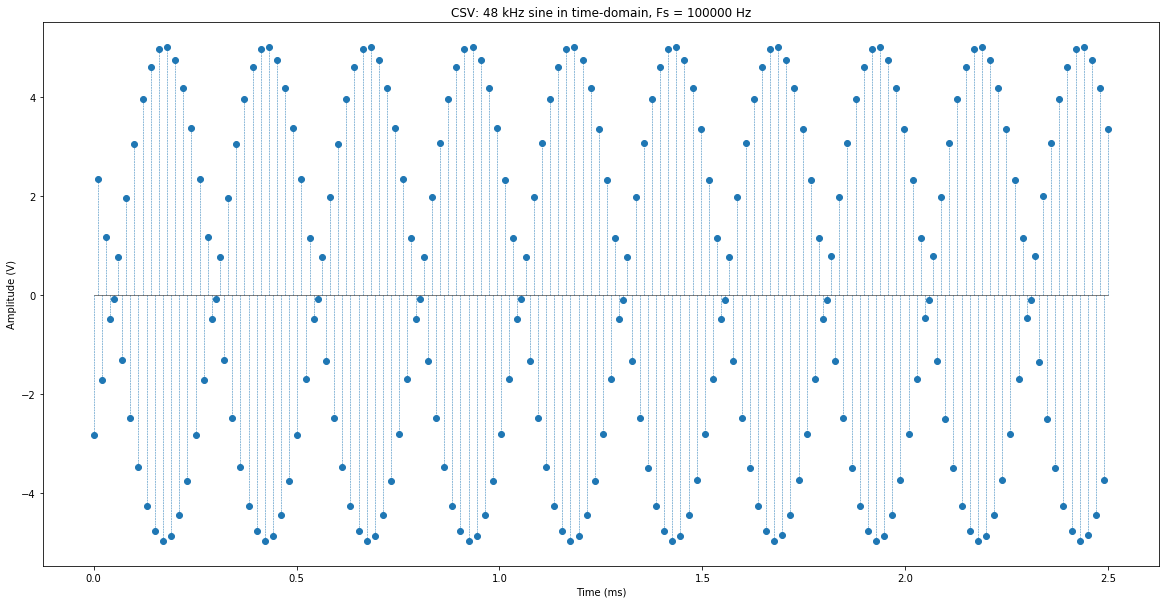

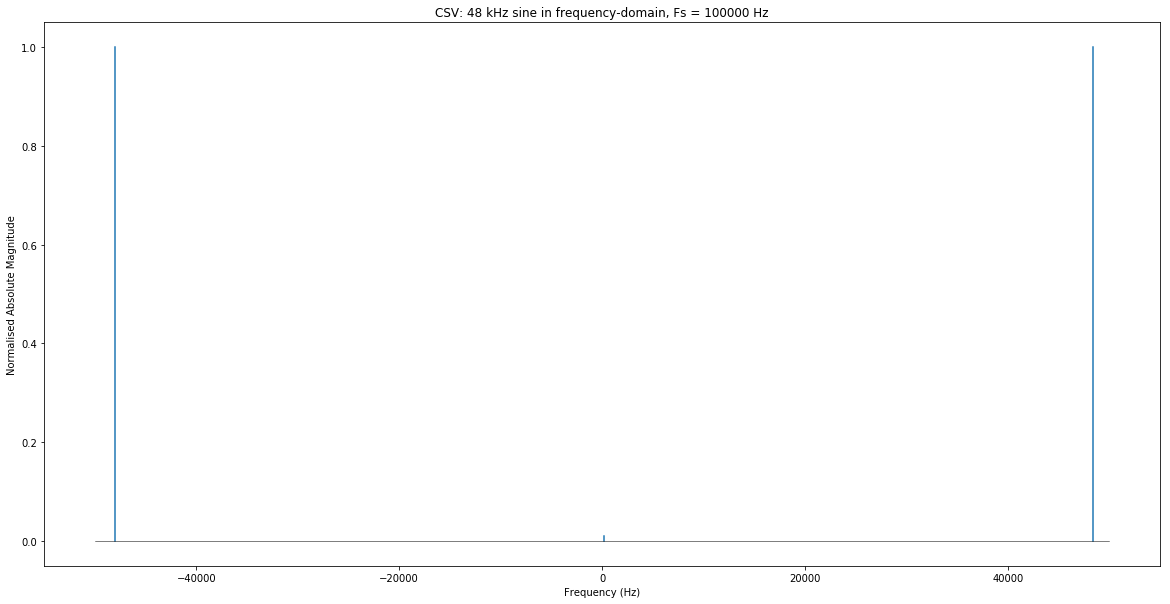

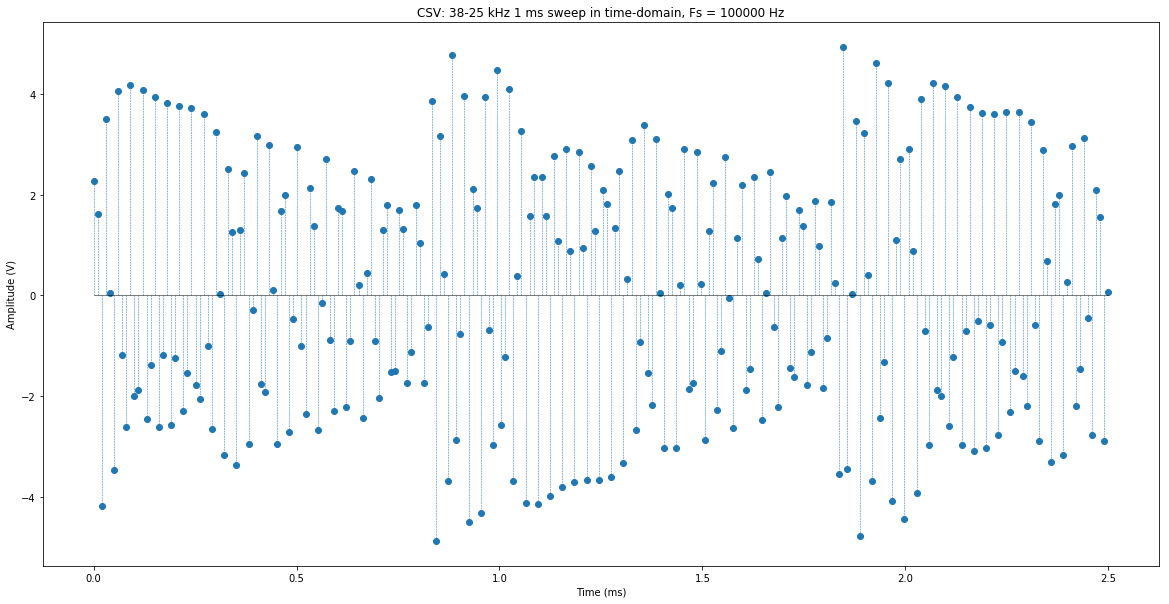

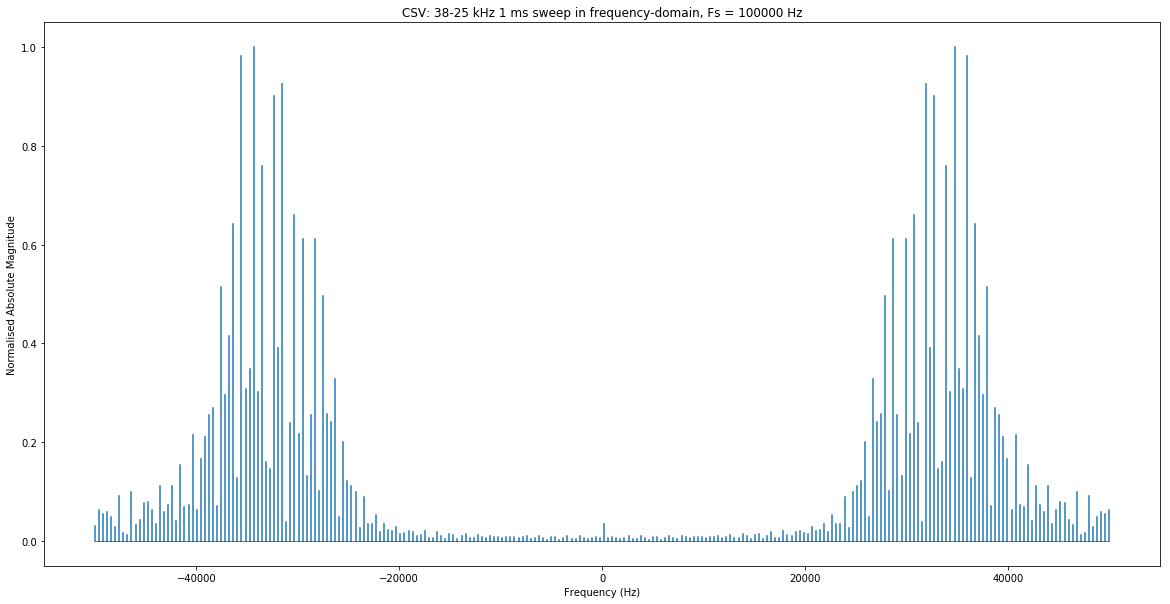

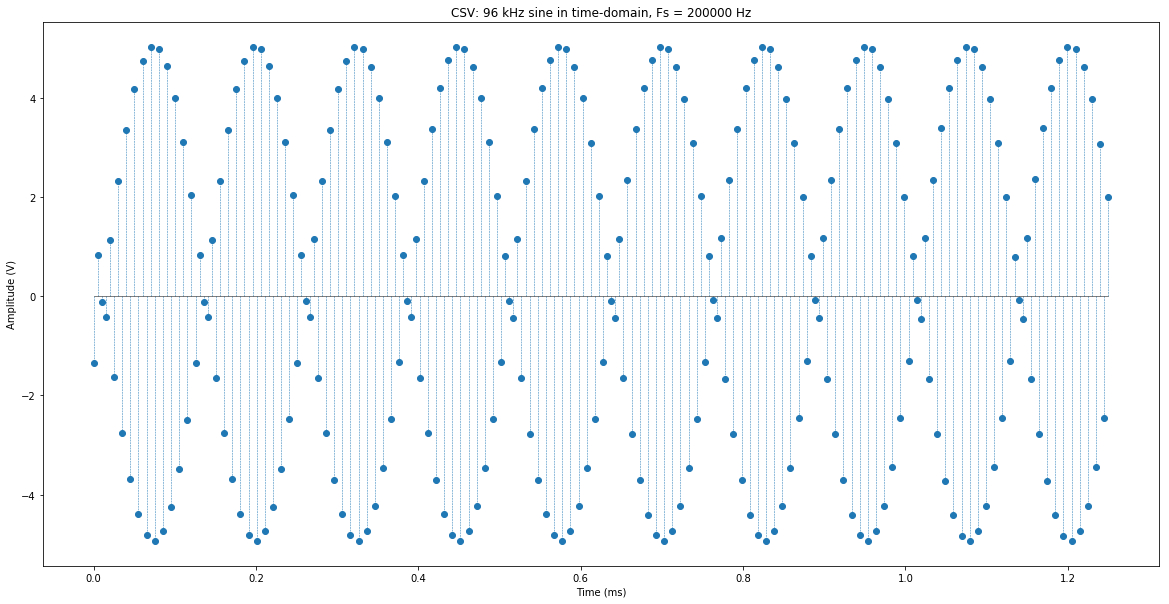

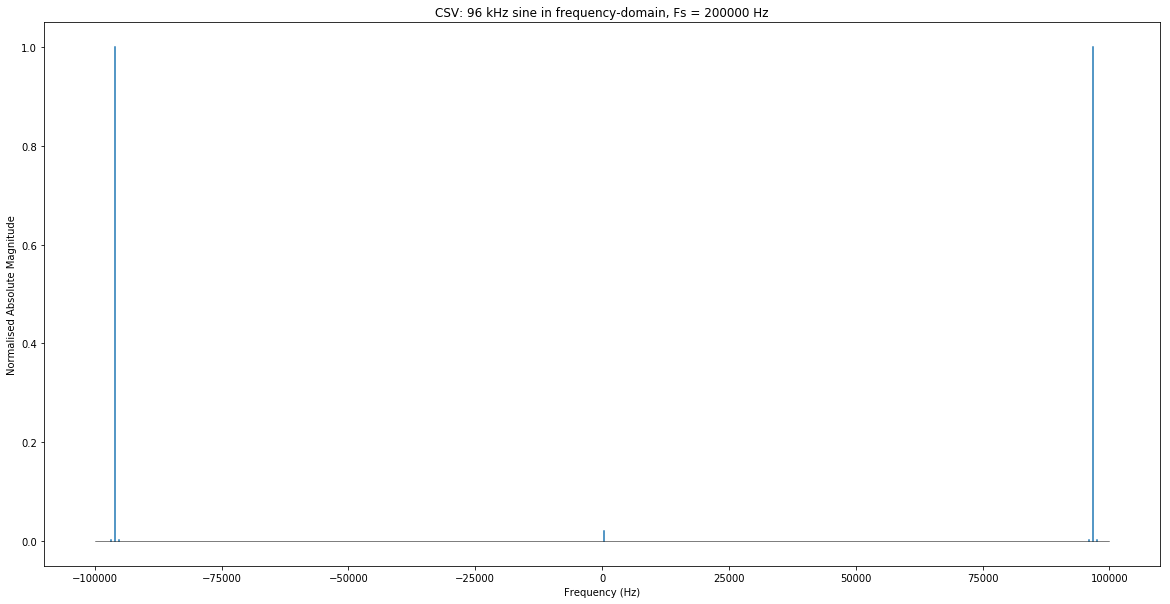

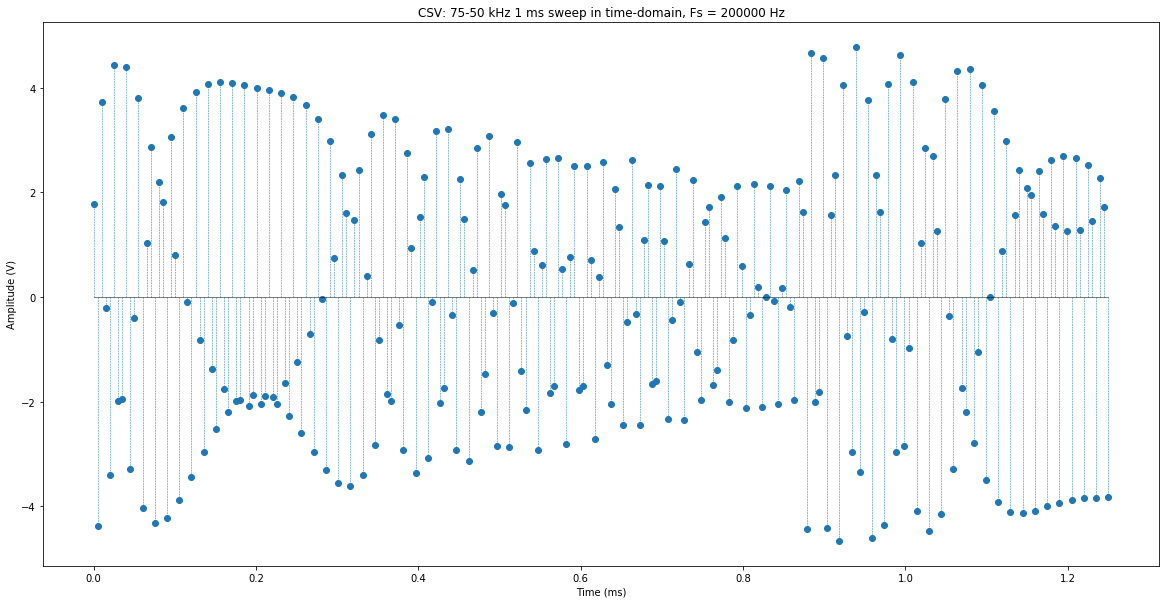

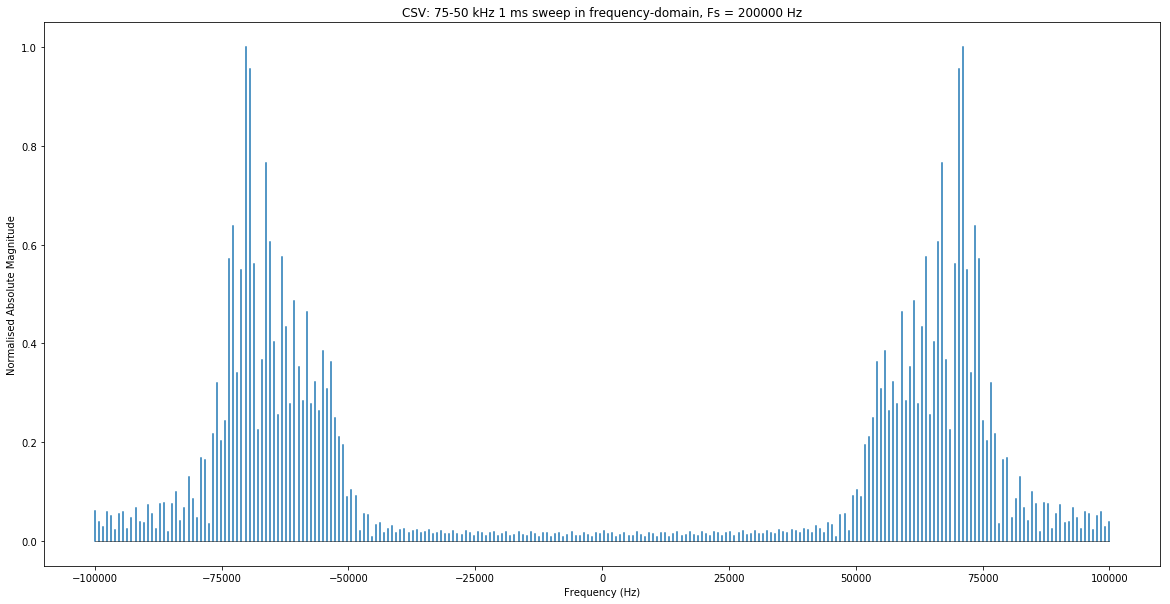

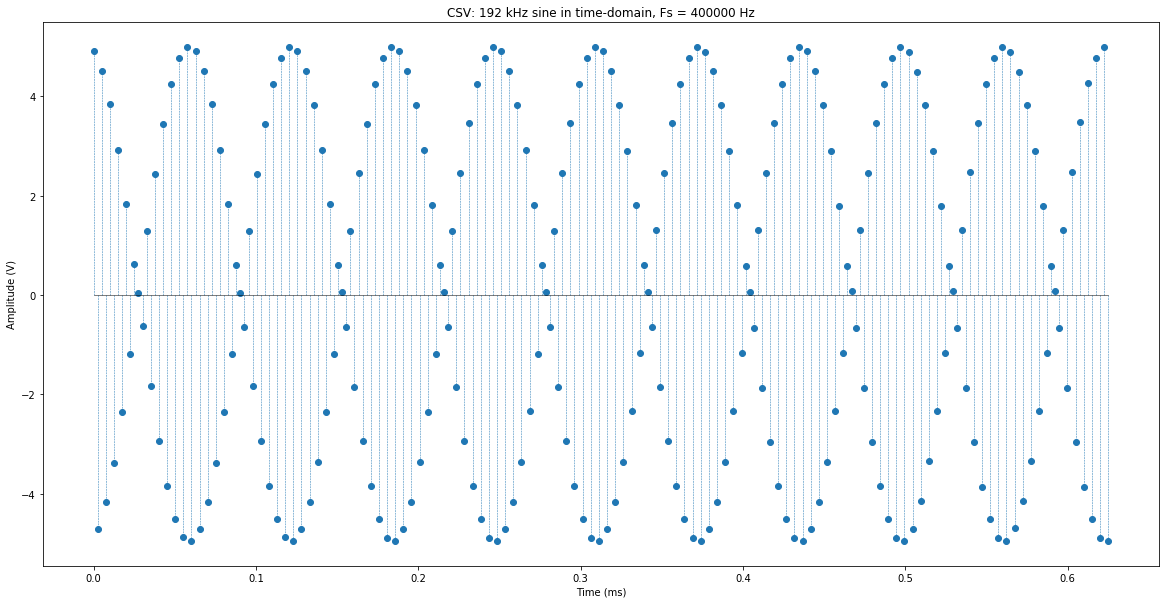

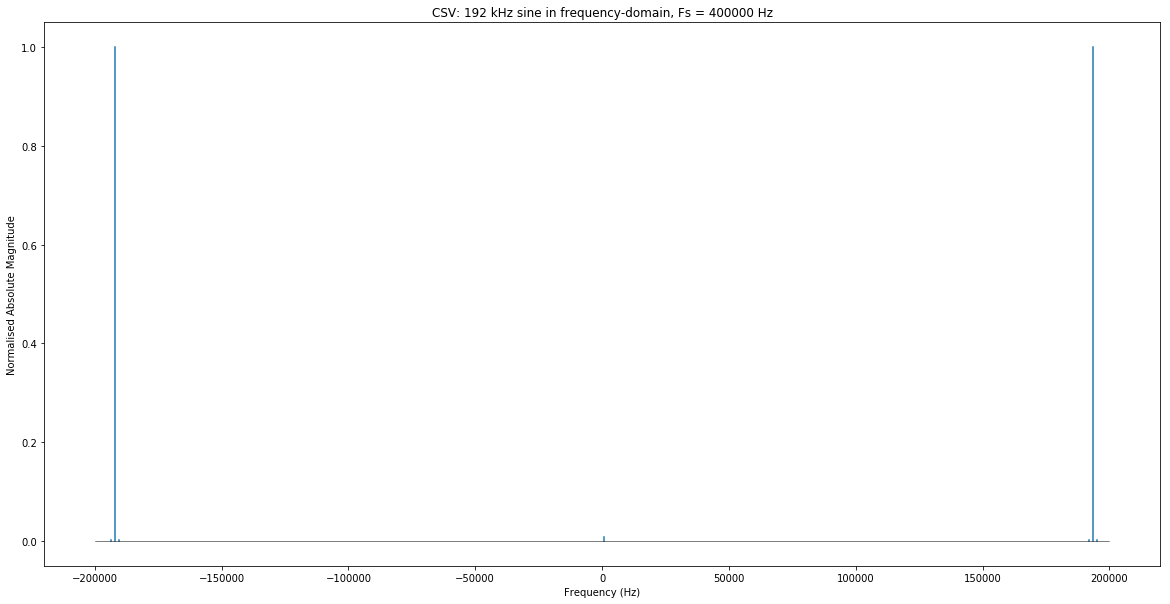

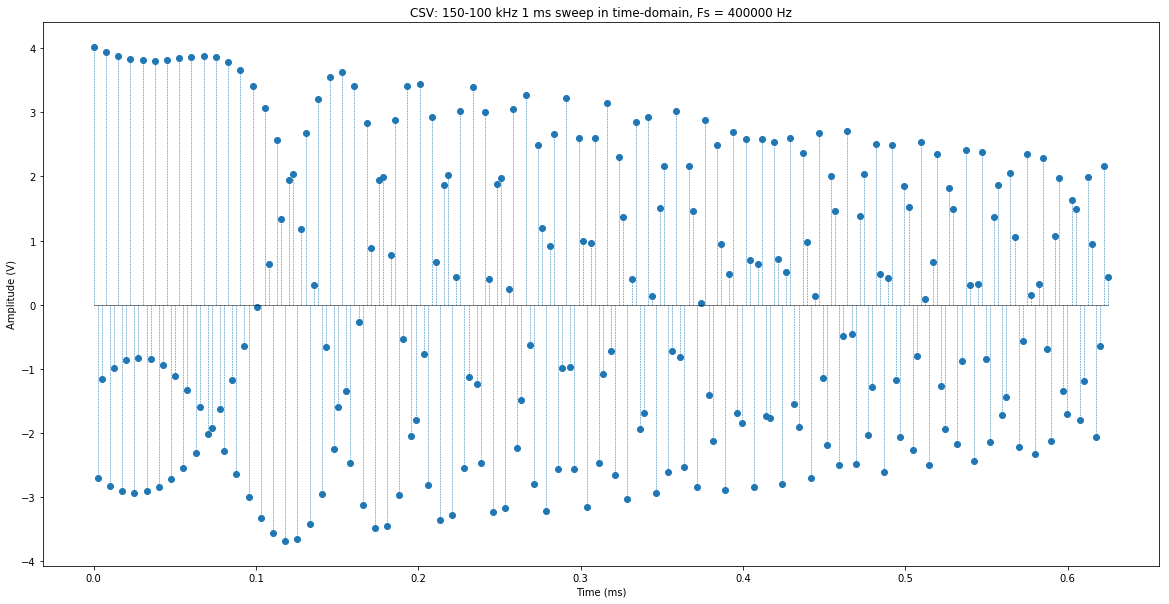

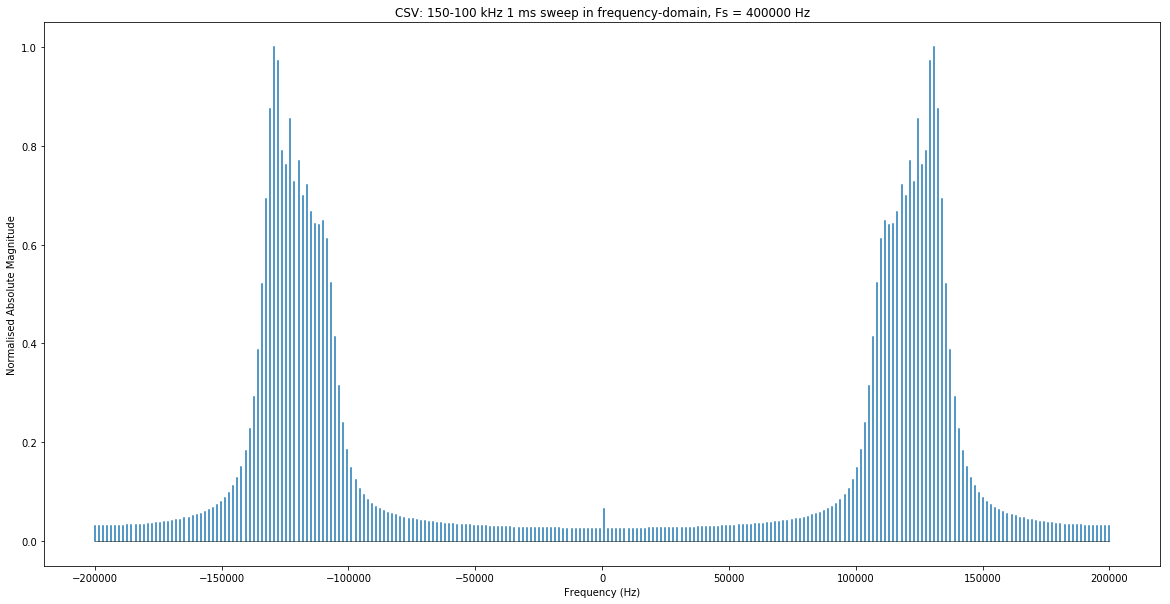

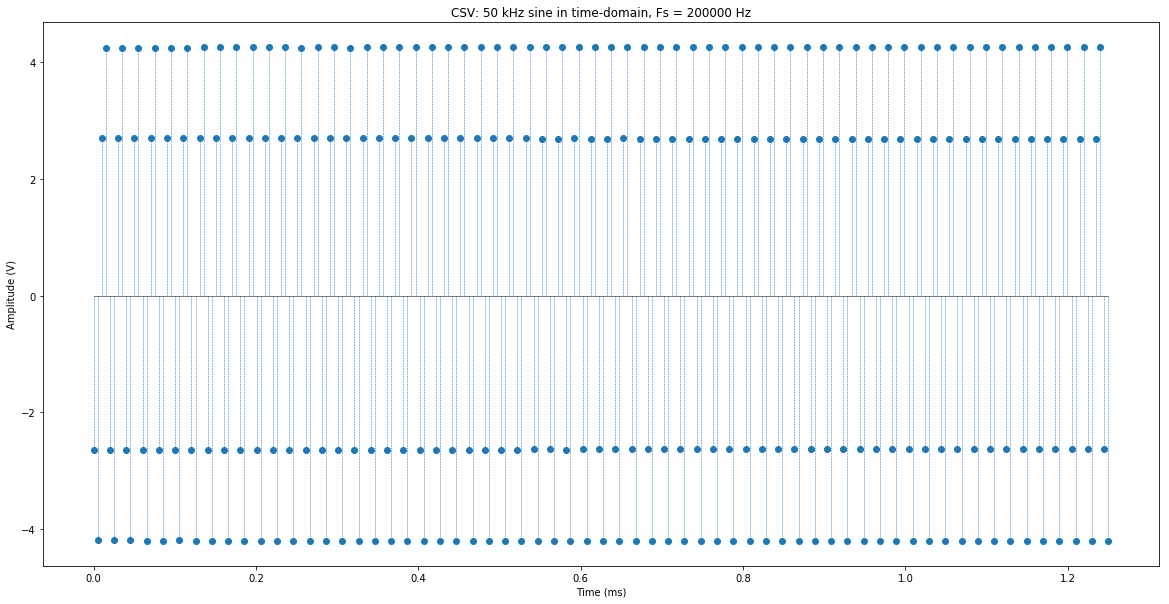

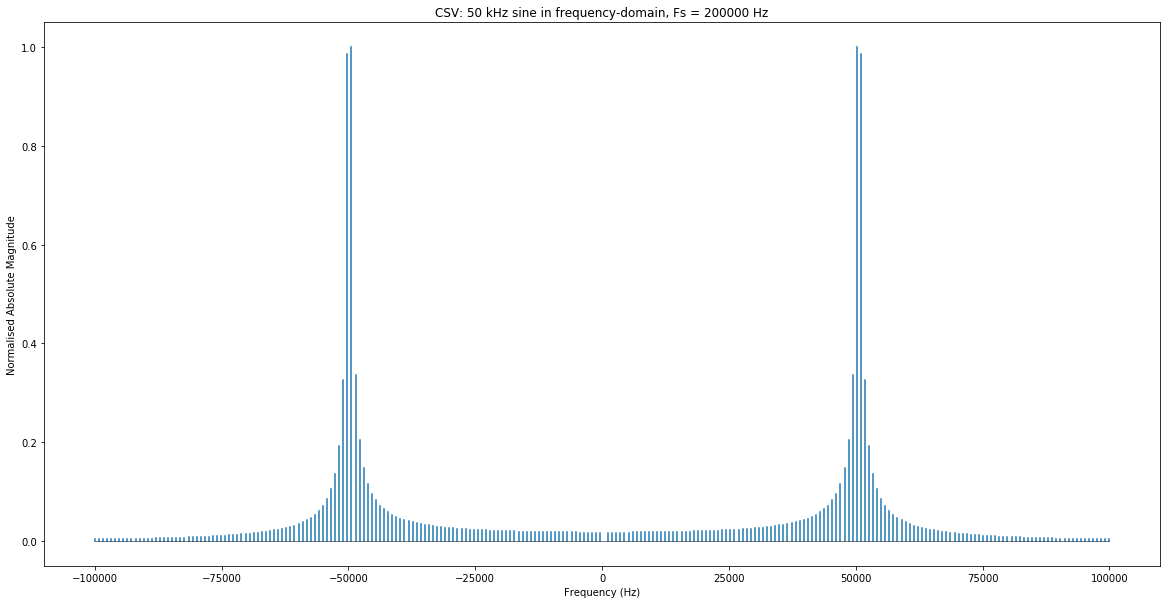

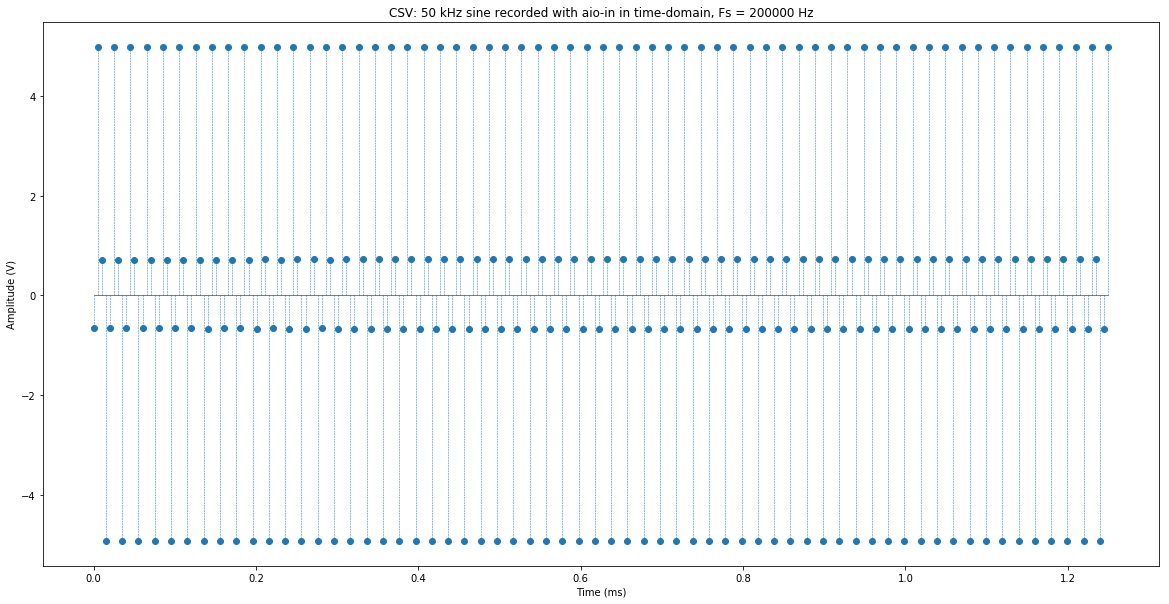

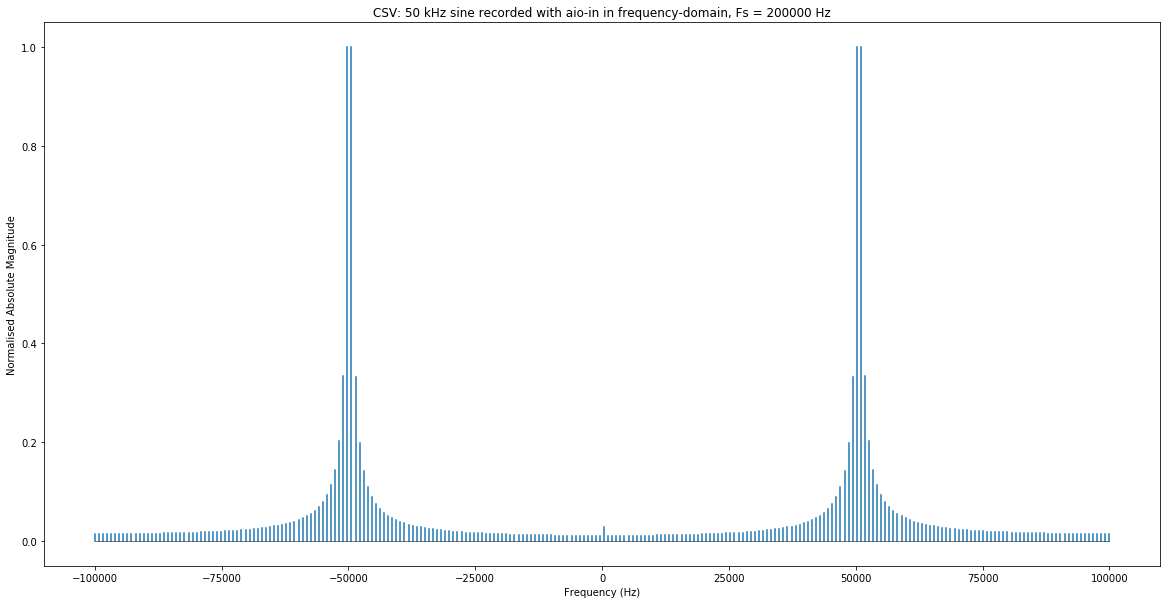

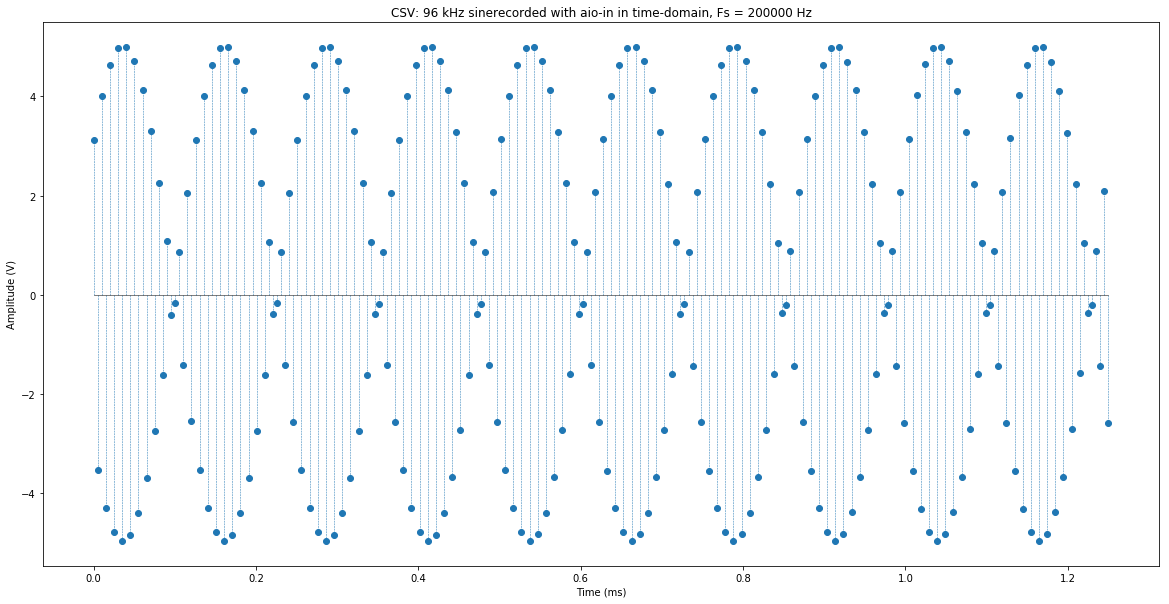

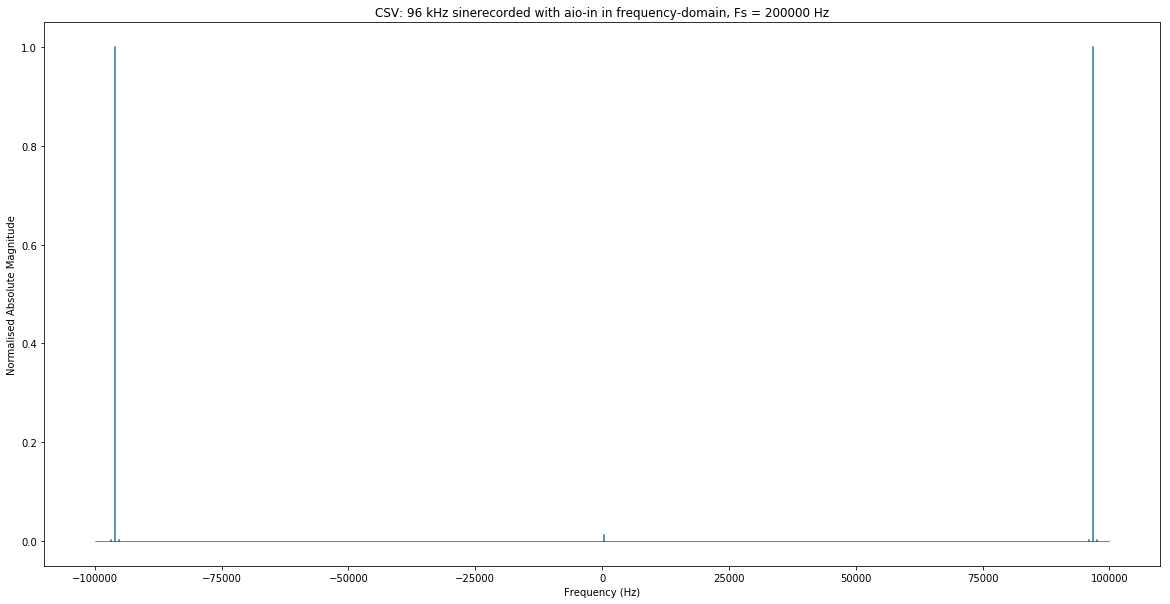

In [9]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import pandas as pd

# CSV

N0 = 0 # initial sample (initial time = N / fs)
N = 250 # final sample (final time = N / fs)


csvDict = {
    "48 kHz sine": 
    "csv/100/sine/48kHz100_20180909T024527672838Z.csv",
    
    "38-25 kHz 1 ms sweep": 
    "csv/100/sweep/38-25kHz100_20131219T02090670580Z.csv",
    
    "96 kHz sine": 
    "csv/200/sine/96kHz200_20180909T033007480050Z.csv",
    
    "75-50 kHz 1 ms sweep": 
    "csv/200/sweep/75-50kHz200_20131219T021143244776Z.csv",
    
    "192 kHz sine": 
    "csv/400/sine/192kHz400_20131219T021907434105Z.csv",
    
    "150-100 kHz 1 ms sweep": 
    "csv/400/sweep/150-100kHz400_20131219T021421308345Z.csv",
    
    "50 kHz sine": 
    "tests/50kHz200_20180910T011832538989Z.csv",
    
    "50 kHz sine recorded with aio-in": 
    "tests/50kHz200aio.csv",
    
    "96 kHz sinerecorded with aio-in": 
    "tests/96kHz200aio.csv"
}

cvsFreqDict = {
    "48 kHz sine": 100000,
    "38-25 kHz 1 ms sweep": 100000,
    "96 kHz sine": 200000,
    "75-50 kHz 1 ms sweep": 200000,
    "192 kHz sine": 400000,
    "150-100 kHz 1 ms sweep": 400000,
    "50 kHz sine": 200000,
    "50 kHz sine recorded with aio-in": 200000,
    "96 kHz sinerecorded with aio-in": 200000
}

i = 0
for waveform in csvDict:
    fs = cvsFreqDict.get(waveform)
    fileName = csvDict.get(waveform)
    fileCSV = pd.read_csv(fileName)

    allData = fileCSV.values
    volts = 1
    counts = 2
    voltData = allData[:,volts] # analagous to fileCSV.loc[:].iat[1]

    t = 1000*np.linspace(N0, N, N-N0)/fs
    plt.figure(2*i + 1, figsize=(20,10))
    markerline, stemlines, baseline = plt.stem(t, voltData[N0:N], linefmt='C0--')
    plt.setp(baseline, linewidth=0.5, color='black')
    plt.setp(stemlines, linewidth=0.5)
    plt.title('CSV: ' + waveform + ' in time-domain, Fs = ' + str(fs) + ' Hz')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (V)')
    plt.show()

    voltFFT = np.fft.fft(voltData[N0:N])
    f = np.linspace(-fs/2,(fs/2)-1,len(voltFFT))
    plt.figure(2*i + 2, figsize=(20,10))
    fftMag = abs(np.fft.fftshift(voltFFT))
    markerline, stemlines, baseline = plt.stem(f, fftMag/max(fftMag), markerfmt=' ')
    plt.setp(baseline, linewidth=0.5, color='black')
    plt.title('CSV: ' + waveform + ' in frequency-domain, Fs = ' + str(fs) + ' Hz')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalised Absolute Magnitude')
    plt.show()
    
    i += 1

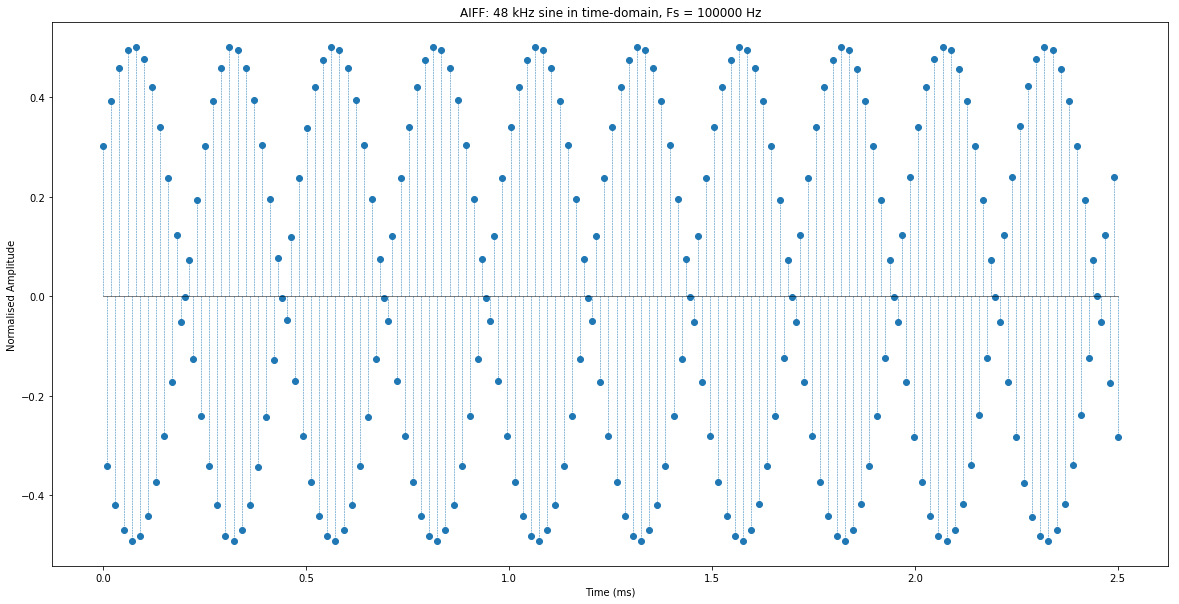

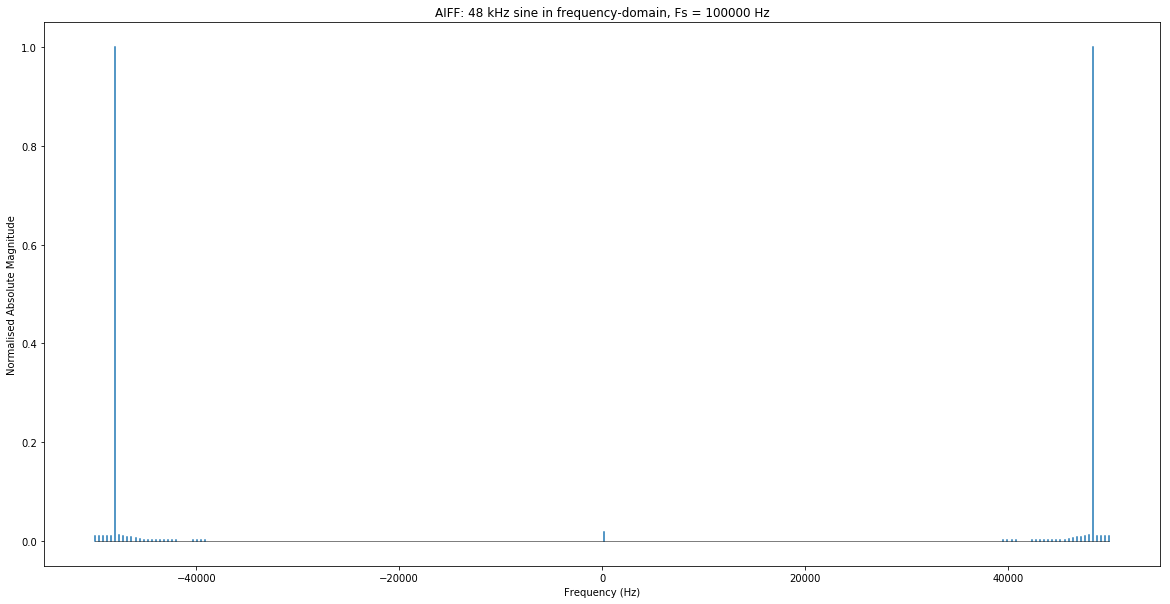

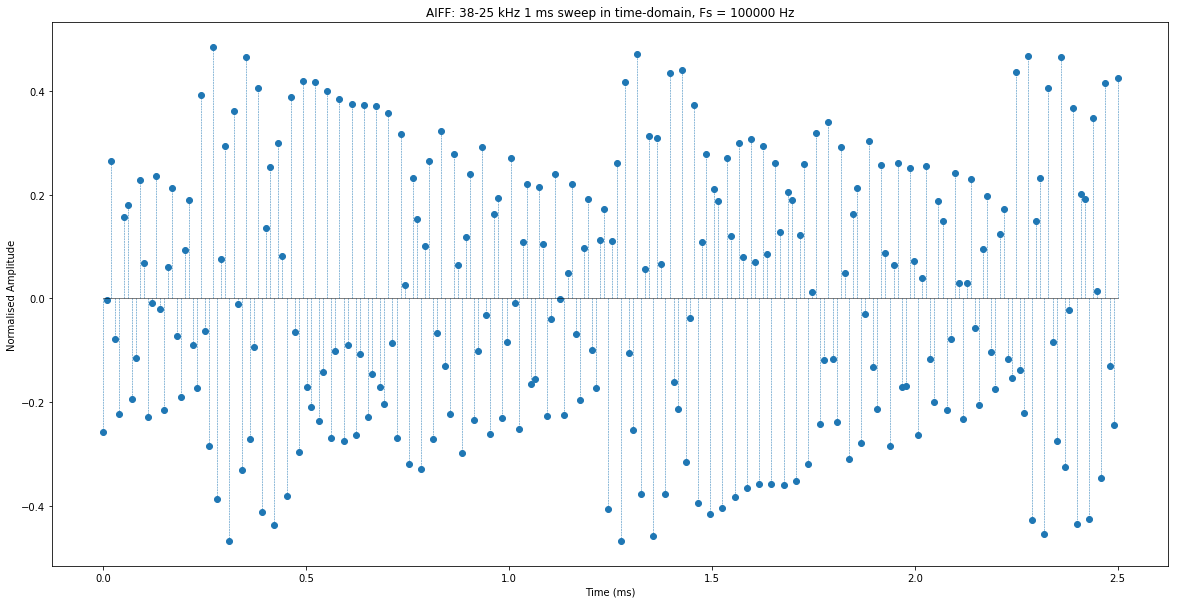

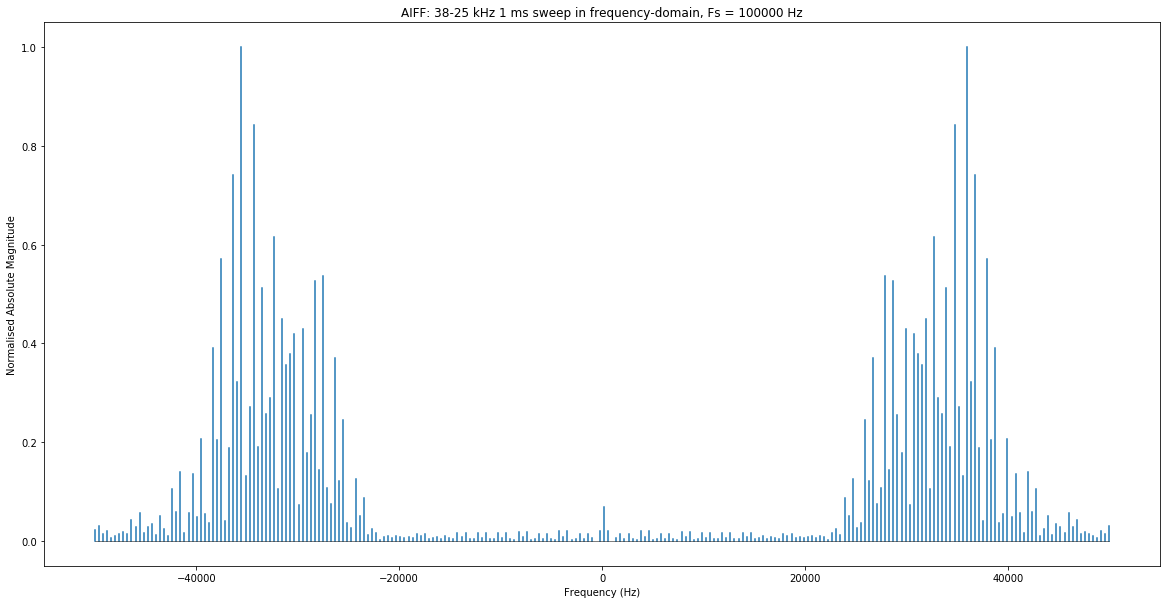

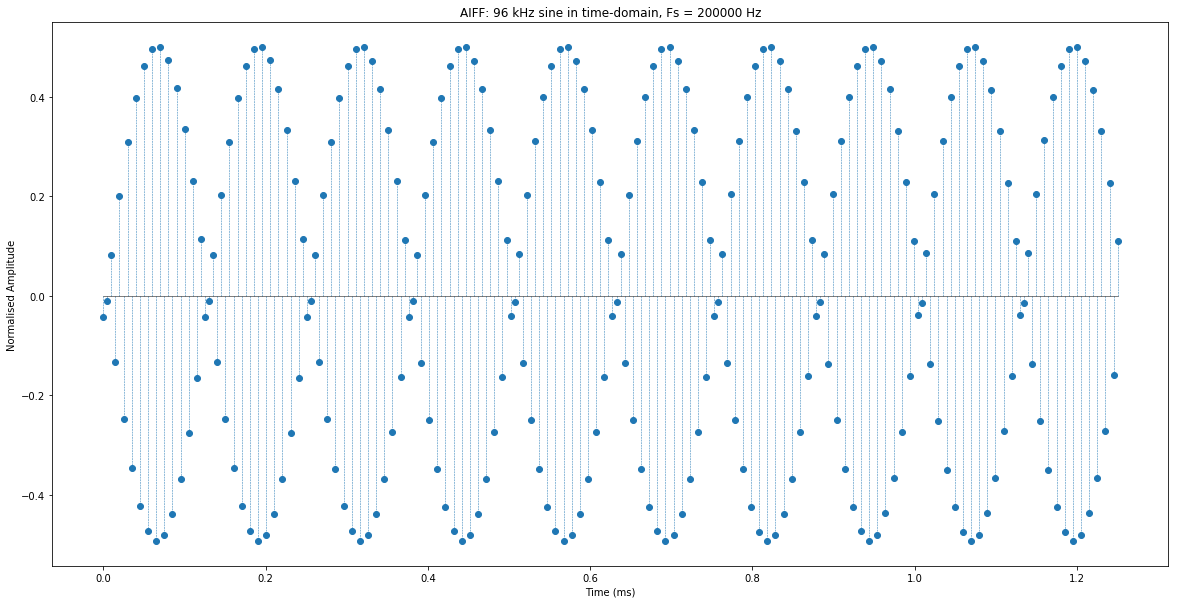

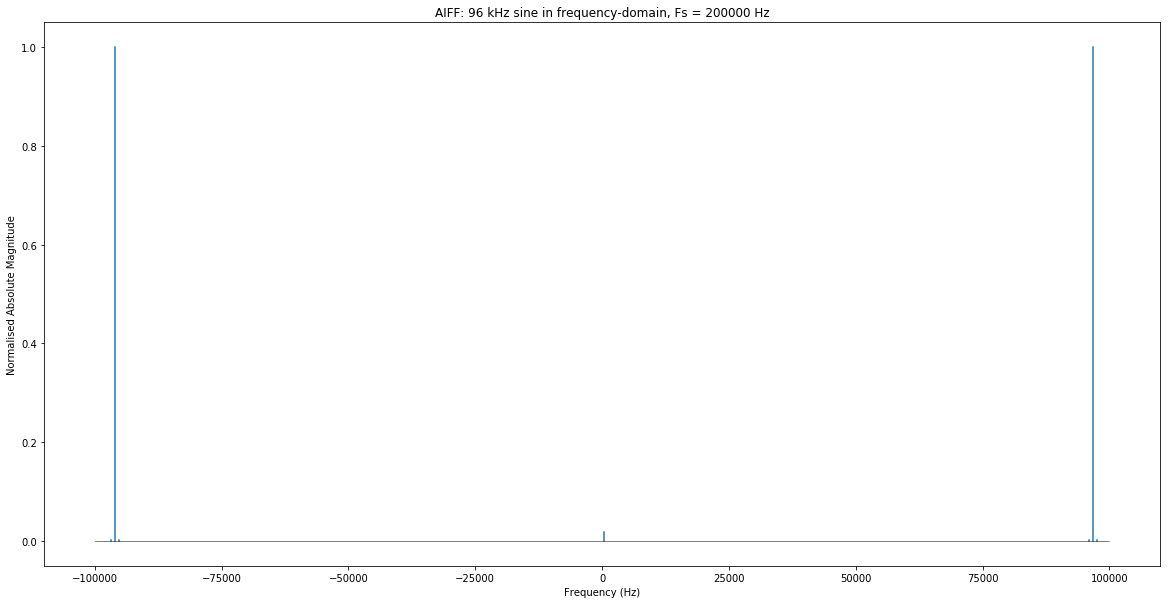

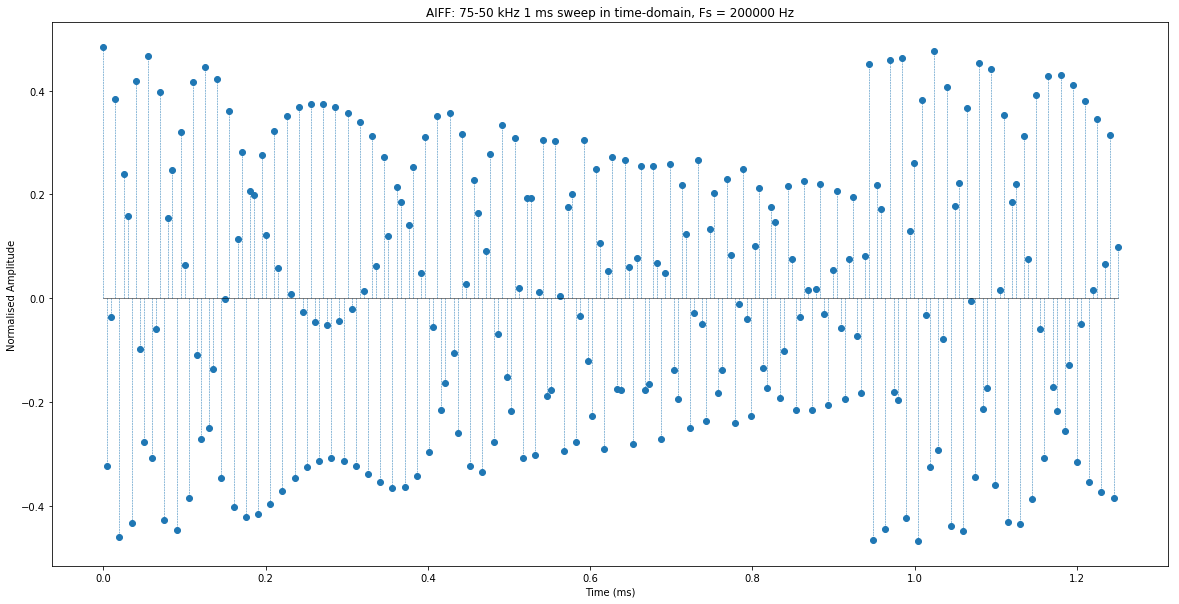

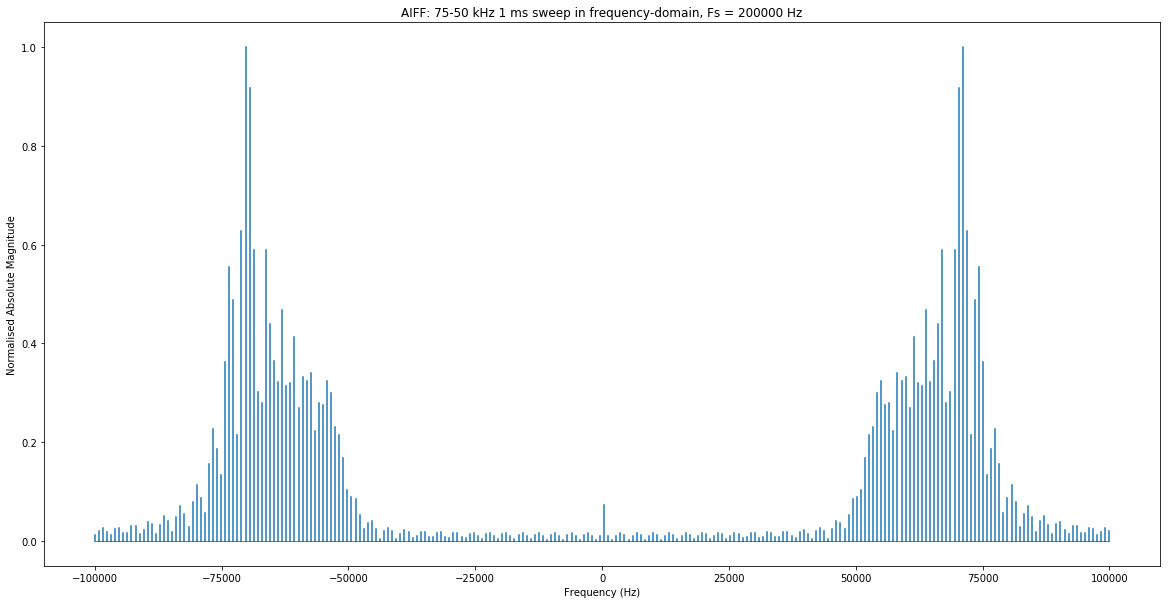

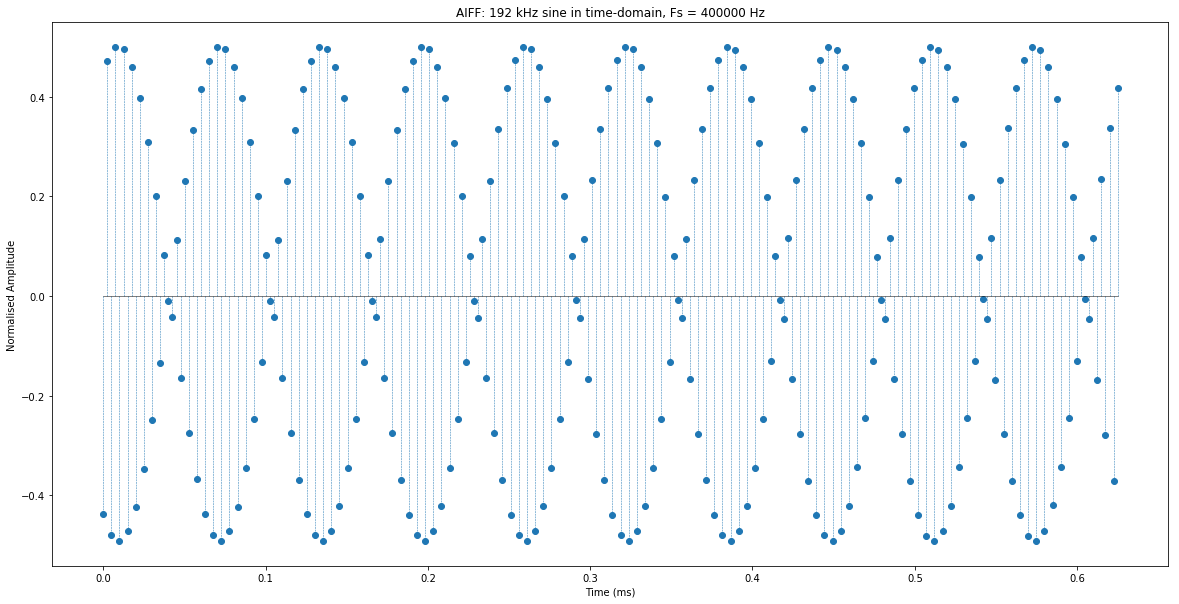

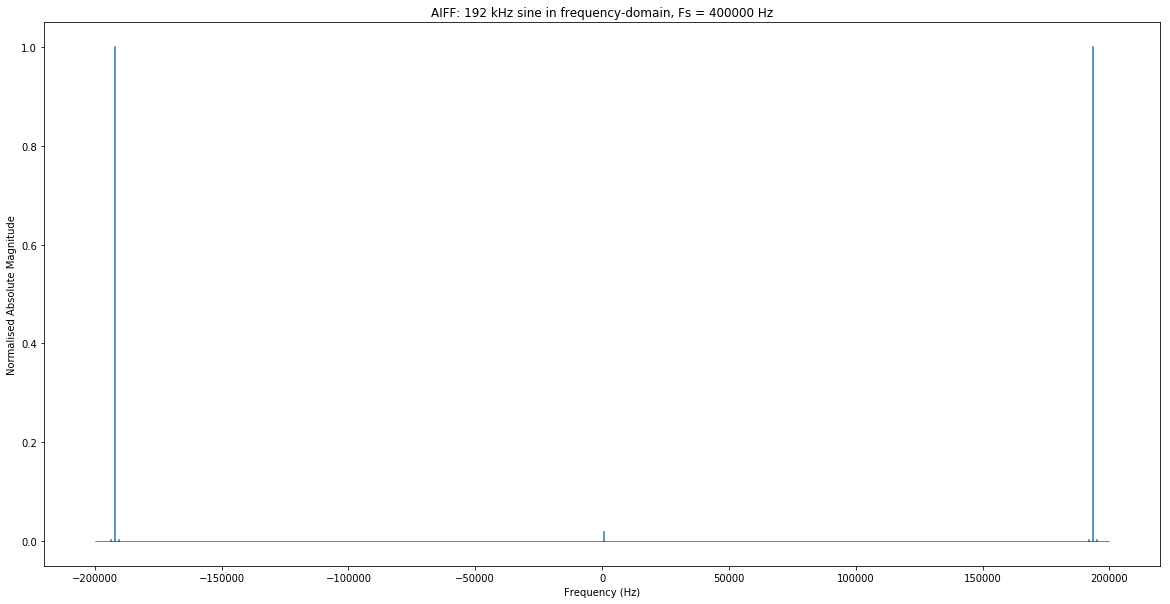

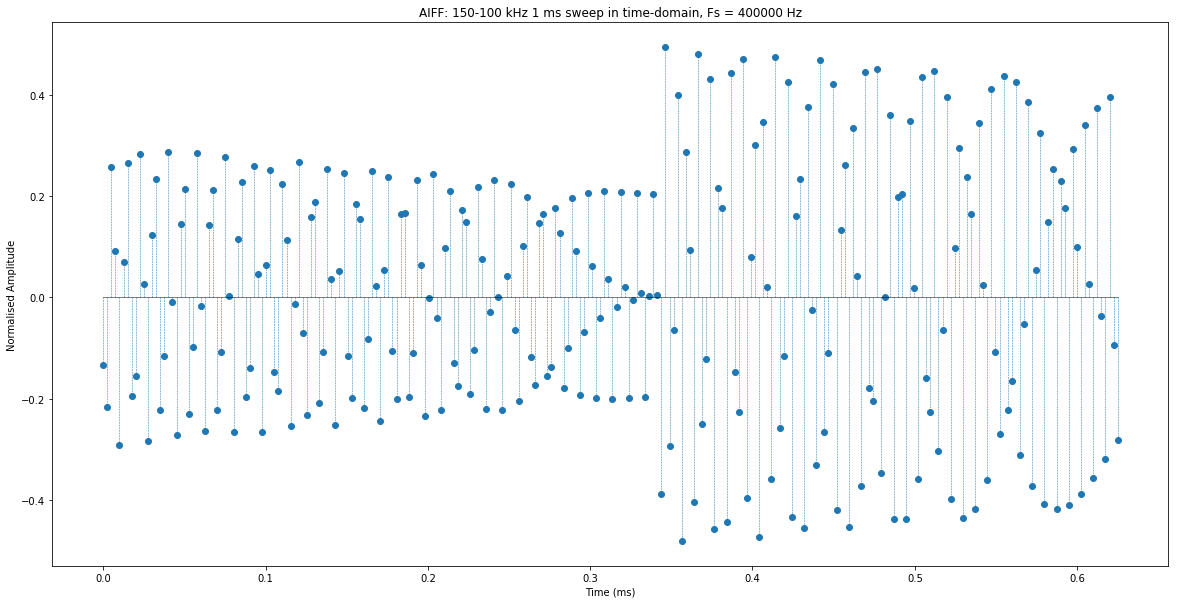

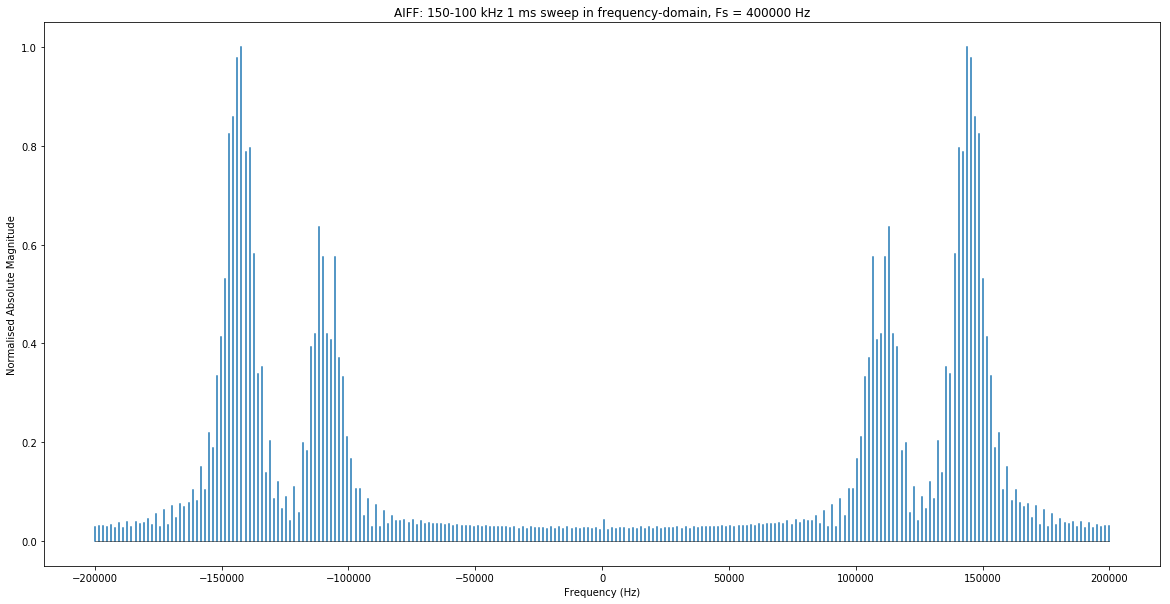

In [10]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf

# AIFF

N0 = 0 # initial sample (initial time = N / fs)
N = 250 # final sample (final time = N / fs)

    
aiffDict = {
    "48 kHz sine": 
    "aiff/100/sine/48kHz100_20180911T062226700725Z.aiff",
    
    "38-25 kHz 1 ms sweep": 
    "aiff/100/sweep/38-25kHz100_20180911T06432384485Z.aiff",
    
    "96 kHz sine": 
    "aiff/200/sine/96kHz200_20180911T062911695433Z.aiff",
    
    "75-50 kHz 1 ms sweep": 
    "aiff/200/sweep/75-50kHz200_20180911T064630568199Z.aiff",
    
    "192 kHz sine": 
    "aiff/400/sine/192kHz400_20180911T063429741633Z.aiff",
    
    "150-100 kHz 1 ms sweep": 
    "aiff/400/sweep/150-100kHz400_20180911T0653024680Z.aiff",
}

i = 0
for waveform in aiffDict:
    fileName = aiffDict.get(waveform)
    fileAIFF, fs = sf.read(fileName)
    
    t = 1000*np.linspace(N0, N, N-N0)/fs
    plt.figure(2*i + 1, figsize=(20,10))
    markerline, stemlines, baseline = plt.stem(t, fileAIFF[N0:N], linefmt='C0--')
    plt.setp(baseline, linewidth=0.5, color='black')
    plt.setp(stemlines, linewidth=0.5)
    plt.title('AIFF: ' + waveform + ' in time-domain, Fs = ' + str(fs) + ' Hz')
    plt.xlabel('Time (ms)')
    plt.ylabel('Normalised Amplitude')
    plt.show()

    fileFFT = np.fft.fft(fileAIFF[N0:N])
    f = np.linspace(-fs/2,(fs/2)-1,len(fileFFT))
    plt.figure(2*i + 2, figsize=(20,10))
    fftMag = abs(np.fft.fftshift(fileFFT))
    markerline, stemlines, baseline = plt.stem(f, fftMag/max(fftMag), markerfmt=' ')
    plt.setp(baseline, linewidth=0.5, color='black')
    plt.title('AIFF: ' + waveform + ' in frequency-domain, Fs = ' + str(fs) + ' Hz')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalised Absolute Magnitude')
    plt.show()
    
    i += 1

In [16]:
import numpy as np
from collections import deque
import pandas as pd
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Button, Slider


class AnalogPlot:

    def __init__(self, data, display_len, ymin, ymax, fileType, waveform, Fs):
        self.buff = deque(np.zeros(display_len))
        self.display_len = display_len
        self.data = data

        # set up the plot
        self.fig = plt.figure(figsize=(20,10))
        self.ax = self.fig.add_subplot(111, xlim=(0, display_len), ylim=(ymin, ymax))
        self.ax.set_xticks((0, display_len))
        self.ax.set_title("%s: %s Fs = %d Hz (1 sample = %0.3f ms)" \
                           % (fileType, waveform, Fs, 1000/Fs))
        self.lines = self.ax.plot([], [])

        # setup the animation
        self.cur_frame = 0
        self.anim = animation.FuncAnimation(self.fig, self._update,
                                            interval=10) # interval delay in ms

        # setup the animation control
        self.anim_running = True

    def _add_to_buff(self, buf, val):
        if len(buf) < self.display_len:
            buf.appendLeft(val)
        else:
            buf.popleft()
            buf.append(val)

    def _update(self, frame):
        frame = self.cur_frame
        self._add_to_buff(self.buff, self.data[frame:frame+1])
        self.lines[0].set_data(range(self.display_len), self.buff)

        self.ax.set_xticklabels((str(frame), str(frame+self.display_len)))

        self.time_slider.eventson = False
        self.time_slider.set_val(frame)
        self.time_slider.eventson = True

        self.cur_frame += 1

        return self.lines

    def _pause(self, event):
        if self.anim_running:
            self.anim.event_source.stop()
            self.anim_running = False
        else:
            self.anim.event_source.start()
            self.anim_running = True

    def _reset(self, event):
        self._set_val(0)

    def _set_val(self, frame=0):
        frame = int(frame)
        self.cur_frame = frame
        new_start = frame - self.display_len
        if new_start >= 0:
            self.buff = deque(self.data[new_start:frame])
        else:
            self.buff = deque(np.concatenate((np.zeros(np.abs(new_start)),
                                              self.data[:frame])))

        self.anim.event_source.stop()
        self.anim = animation.FuncAnimation(self.fig, self._update,
                                            interval=10) # interval delay in ms
        self.anim_running = True

    def animate(self):
        pause_ax = self.fig.add_axes((0.7, 0.025, 0.1, 0.04))
        pause_button = Button(pause_ax, 'pause', hovercolor='0.975')
        pause_button.on_clicked(self._pause)

        reset_ax = self.fig.add_axes((0.8, 0.025, 0.1, 0.04))
        reset_button = Button(reset_ax, 'reset', hovercolor='0.975')
        reset_button.on_clicked(self._reset)

        slider_ax = self.fig.add_axes((0.1, 0.025, 0.5, 0.04))
        self.time_slider = Slider(slider_ax, label='Samples',
                                  valmin=0, valmax=self.data.shape[0],
                                  valinit=0.0)

        self.time_slider.on_changed(self._set_val)

        plt.show()

#####

csvDict = {
    "48 kHz sine": 
    "csv/100/sine/48kHz100_20180909T024527672838Z.csv",
    
    "38-25 kHz 1 ms sweep": 
    "csv/100/sweep/38-25kHz100_20131219T02090670580Z.csv",
    
    "96 kHz sine": 
    "csv/200/sine/96kHz200_20180909T033007480050Z.csv",
    
    "75-50 kHz 1 ms sweep": 
    "csv/200/sweep/75-50kHz200_20131219T021143244776Z.csv",
    
    "192 kHz sine": 
    "csv/400/sine/192kHz400_20131219T021907434105Z.csv",
    
    "150-100 kHz 1 ms sweep": 
    "csv/400/sweep/150-100kHz400_20131219T021421308345Z.csv",
    
    "50 kHz sine": 
    "tests/50kHz200_20180910T011832538989Z.csv",
    
    "50 kHz sine recorded with aio-in": 
    "tests/50kHz200aio.csv",
    
    "96 kHz sinerecorded with aio-in": 
    "tests/96kHz200aio.csv"
}

cvsFreqDict = {
    "48 kHz sine": 100000,
    "38-25 kHz 1 ms sweep": 100000,
    "96 kHz sine": 200000,
    "75-50 kHz 1 ms sweep": 200000,
    "192 kHz sine": 400000,
    "150-100 kHz 1 ms sweep": 400000,
    "50 kHz sine": 200000,
    "50 kHz sine recorded with aio-in": 200000,
    "96 kHz sinerecorded with aio-in": 200000
}

aiffDict = {
    "48 kHz sine": 
    "aiff/100/sine/48kHz100_20180911T062226700725Z.aiff",
    
    "38-25 kHz 1 ms sweep": 
    "aiff/100/sweep/38-25kHz100_20180911T06432384485Z.aiff",
    
    "96 kHz sine": 
    "aiff/200/sine/96kHz200_20180911T062911695433Z.aiff",
    
    "75-50 kHz 1 ms sweep": 
    "aiff/200/sweep/75-50kHz200_20180911T064630568199Z.aiff",
    
    "192 kHz sine": 
    "aiff/400/sine/192kHz400_20180911T063429741633Z.aiff",
    
    "150-100 kHz 1 ms sweep": 
    "aiff/400/sweep/150-100kHz400_20180911T0653024680Z.aiff",
}

#####

waveform = "48 kHz sine"
fileType = "aiff"

if fileType is "csv":
    fs = cvsFreqDict.get(waveform)
    fileName = csvDict.get(waveform)
    fileCSV = pd.read_csv(fileName)

    allData = fileCSV.values
    voltData = allData[:, 1] # analagous to fileCSV.loc[:].iat[1]
    countData = allData[:, 2]

    ymin = -10
    ymax = 10
elif fileType is "aiff":
    fileName = aiffDict.get(waveform)
    fileAIFF, fs = sf.read(fileName)
    voltData = fileAIFF

    ymin = -1
    ymax = 1
else:
    print("invalid file type\n")

n_max = 100 # samples per frame
analog_plot = AnalogPlot(voltData, n_max, ymin, ymax, fileType, waveform, fs)
analog_plot.animate()


In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

# CSV moving picture frame-by-frame plotter

plot = 'time'; #'time', 'spikes'
waveform = "48 kHz sine"

T = 500; # samples per frame
wait = 2; # delay in seconds

N0 = 0 # initial frame
N = 10 # final frame

#####

csvDict = {
    "48 kHz sine": 
    "csv/100/sine/48kHz100_20180909T024527672838Z.csv",
    
    "38-25 kHz 1 ms sweep": 
    "csv/100/sweep/38-25kHz100_20131219T02090670580Z.csv",
    
    "96 kHz sine": 
    "csv/200/sine/96kHz200_20180909T033007480050Z.csv",
    
    "75-50 kHz 1 ms sweep": 
    "csv/200/sweep/75-50kHz200_20131219T021143244776Z.csv",
    
    "192 kHz sine": 
    "csv/400/sine/192kHz400_20131219T021907434105Z.csv",
    
    "150-100 kHz 1 ms sweep": 
    "csv/400/sweep/150-100kHz400_20131219T021421308345Z.csv",
    
    "50 kHz sine": 
    "tests/50kHz200_20180910T011832538989Z.csv",
    
    "50 kHz sine recorded with aio-in": 
    "tests/50kHz200aio.csv",
    
    "96 kHz sinerecorded with aio-in": 
    "tests/96kHz200aio.csv"
}

cvsFreqDict = {
    "48 kHz sine": 100000,
    "38-25 kHz 1 ms sweep": 100000,
    "96 kHz sine": 200000,
    "75-50 kHz 1 ms sweep": 200000,
    "192 kHz sine": 400000,
    "150-100 kHz 1 ms sweep": 400000,
    "50 kHz sine": 200000,
    "50 kHz sine recorded with aio-in": 200000,
    "96 kHz sinerecorded with aio-in": 200000
}

#####

fs = cvsFreqDict.get(waveform)
fileName = csvDict.get(waveform)
fileCSV = pd.read_csv(fileName)

allData = fileCSV.values
voltData = allData[:, 1] # analagous to fileCSV.loc[:].iat[1]
countData = allData[:, 2]

N_max = math.floor(len(voltData) / T)

if plot is 'time':
    if (N0 >= 0) and (N0 <= N) and (N <= N_max):
        frames = range(N0, N)

        plt.ion()
        plt.show()
        for i in frames:
            n0 = T * i # initial sample
            n = n0 + T # final sample
            ni = np.array(range(n0, n))
            ti = ni * 1000 / fs
            plt.figure(figsize=(20,10))
            markerline, stemlines, baseline = plt.stem(ti, voltData[ni], linefmt='C0--')
            plt.setp(baseline, linewidth=0.5, color='black')
            plt.setp(stemlines, linewidth=0.5)
            plt.title('CSV %s (Fs = %d Hz): Frame %d / %d' % (waveform, fs, i + 1, N))
            plt.ylim(-10, 10)
            plt.xlim(ti[0], ti[-1])
            plt.ylabel('Amplitude (V)')
            plt.xlabel('Time (ms)')
            plt.draw() 
            plt.pause(wait)
            plt.close()
    else:
        print("Error: initial frame number %d must be:\n" % N0)
        print("\t no more than the final frame number %d\n" % N)
        print("\t at least 0\n")
elif plot is 'spikes':
    thres = 5.1 # 5 V + 2%
    data = np.array(voltData)
    diff = data * (abs(data) > thres)
    indices = np.where(diff > 0)
    plt.scatter(indices, diff[indices])
    plt.grid()
    plt.title('Spikes')
    plt.xlabel('Sample')
    plt.xlim(0, len(data) - 1)
    plt.ylabel('Amplitude (V)')
    plt.ylim(-10, 10)
    plt.show() 